In [1]:
import pandas as pd
import os
from keras.utils import img_to_array, load_img
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Step 1: Load dataset
df = pd.DataFrame(columns=['imagePath', 'label'])

directories = {
    "ayam": "./dataset/ayam_goreng/",
    "ayam": "./dataset/ayam_pop/",
    "daging_rendang": "./dataset/daging_rendang/",
    "dendeng_batokok": "./dataset/dendeng_batokok/",
    "gulai_ikan": "./dataset/gulai_ikan/",
    "gulai_tambusu": "./dataset/gulai_tambusu/",
    "telur_balado": "./dataset/telur_balado/",
    "telur_dadar": "./dataset/telur_dadar/",
    "tahu": "./dataset/tahu/",
    "daun_singkong": "./dataset/daun_singkong/",
    "perkedel": "./dataset/perkedel/",
    "nasi": "./dataset/nasi/",
    'tempe': "./dataset/tempe_goreng/",
    "telur_mata_sapi": "./dataset/telur_matasapi/",
    "mie" : "./dataset/mi/",
    "udang" : "./dataset/udang/"
}

for label, directory in directories.items():
    for i in os.listdir(directory):
        df = pd.concat([df, pd.DataFrame({'imagePath': [f"{directory}/{i}"], 'label': [label]})])

df = df.reset_index(drop=True)

c:\Users\lenovo\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
imgs = []
for image_path in df['imagePath']:
    img = load_img(image_path, target_size=(101, 101)).convert('RGB')
    img_array = img_to_array(img)
    imgs.append(img_array)

df['img'] = imgs

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

le = LabelEncoder()
y = le.fit_transform(df['label'])
scaler = StandardScaler()

x = np.array(df['img'].tolist())
x = x /255

y = to_categorical(y, num_classes=len(np.unique(y)))

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=32)
for train_index, test_index in sss.split(x, np.argmax(y, axis=1)):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [4]:
from tensorflow.keras import models
from keras import layers
model = models.Sequential()
numOfLabel = len(np.unique(list(directories.keys())))

model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(x[0].shape)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(numOfLabel, activation='softmax'))  # Assuming 10 classes for classification

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 99, 99, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 256)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 23, 23, 256)       0

In [5]:
# from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
)
datagen.fit(X_train)

In [6]:
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    # X_train, y_train,
    datagen.flow(X_train, y_train, batch_size=128),
    epochs=100,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/100
23/23 [==============================] - 13s 298ms/step - loss: 2.4120 - accuracy: 0.2518 - val_loss: 4.3214 - val_accuracy: 0.1566
Epoch 2/100
23/23 [==============================] - 5s 224ms/step - loss: 1.8518 - accuracy: 0.3946 - val_loss: 2.2192 - val_accuracy: 0.3879
Epoch 3/100
23/23 [==============================] - 5s 194ms/step - loss: 1.6040 - accuracy: 0.4803 - val_loss: 3.1345 - val_accuracy: 0.2722
Epoch 4/100
23/23 [==============================] - 5s 226ms/step - loss: 1.5270 - accuracy: 0.5000 - val_loss: 1.5489 - val_accuracy: 0.4683
Epoch 5/100
23/23 [==============================] - 5s 196ms/step - loss: 1.4659 - accuracy: 0.5212 - val_loss: 1.5539 - val_accuracy: 0.4965
Epoch 6/100
23/23 [==============================] - 4s 188ms/step - loss: 1.3639 - accuracy: 0.5501 - val_loss: 1.7454 - val_accuracy: 0.4260
Epoch 7/100
23/23 [==============================] - 5s 231ms/step - loss: 1.3662 - accuracy: 0.5596 - val_loss: 1.3089 - val_accuracy: 0.572

# buat langsung load model tanpa training

In [7]:
from keras.models import load_model

model = load_model("best_model.h5")

# buat testing

In [8]:
y_pred = model.predict(X_test)
y_pred_labels = le.inverse_transform(np.argmax(y_pred, axis=1))
y_true_labels = le.inverse_transform(np.argmax(y_test, axis=1))


23/23 [==============================] - 1s 14ms/step


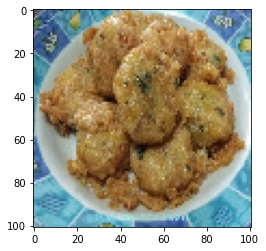

prediction:  perkedel
true label:  perkedel


In [9]:
import matplotlib.pyplot as plt
def testShow (index):
    plt.imshow(X_test[index])
    plt.show()
    print("prediction: ", y_pred_labels[index])
    print("true label: ", y_true_labels[index])
    
testShow(35)

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

                 precision    recall  f1-score   support

           ayam       0.79      0.95      0.86        40
 daging_rendang       0.83      0.91      0.87        43
  daun_singkong       0.85      1.00      0.92        40
dendeng_batokok       0.76      0.80      0.78        40
     gulai_ikan       0.80      0.87      0.83        45
  gulai_tambusu       0.90      0.64      0.75        42
            mie       0.75      0.96      0.84        45
           nasi       0.95      0.97      0.96        40
       perkedel       0.66      0.92      0.77        90
           tahu       0.76      0.57      0.65        46
   telur_balado       0.91      0.74      0.82        43
    telur_dadar       0.87      0.76      0.81        45
telur_mata_sapi       0.98      0.89      0.93        55
          tempe       0.73      0.31      0.44        51
          udang       0.81      0.80      0.80        44

       accuracy                           0.81       709
      macro avg       0.82   